# Restart technique

Let's start by importing basic libraries.

In [1]:
# Add the sibling folders
import sys, os
sys.path.insert(0, os.path.abspath('../..'))
from src.utils import *

import torch.optim as optim
import numpy as np
from sklearn import metrics

# Plot libraries and tables
from IPython.display import HTML, display
import tabulate
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook()

import random as rm

import glob

### Estimating training loss with a sample of the training set

The approach that I'll be covering only uses a sample of minibatches to estimate the training loss and accuracy.

The normal function for assessing the cost loops over all the minibatches and computes the cost. Here it is shown the code.

In [2]:
def test_train(trainloader, model):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    
    # All the batches are here looped
    for data in trainloader:
        images, labels = data
        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()
        test_loss += float(F.cross_entropy(outputs, Variable(labels.cuda())).item())
        del images, labels, outputs

    return test_loss / total, correct / total

With the new function that I wrote, a number of (different) minibatches can be selected to estimate the value. The indexes are selected and sorted, then the cost is computed over the minibatches. 

In [3]:
def test_train_sample(trainloader, model, n_minibatches=1):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    
    # Iterator over the minibatches
    trainiter = iter(trainloader)
    
    # Index 0 is added to ease the next loop but it is not used (unless selected in next operation)
    indexes = [0]

    # Sample the indexes
    indexes.append(random.sample(range(0, len(trainiter) - 2), n_minibatches)) # Last minibatch is left out
    
    # Order the indexes, in such a way the iterator is used only once
    indexes = sorted(indexes)
    
    # Only the selected minibatches are used
    for i in range(1, n_minibatches + 1):
        for j in range(indexes[i] - indexes[i - 1] - 1): # Go to next minibatch
            trainiter.next()

        images, labels = trainiter.next()

        outputs = model(Variable(images.cuda()))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)

        correct += (predicted == labels.cuda()).sum().item()
        test_loss += float(F.cross_entropy(outputs, Variable(labels.cuda())).item())
        del images, labels, outputs

    return test_loss / total, correct / total

Let's take a look now to the behaviour, comparing the two functions.

Results are loaded from a cluster computation. A basic SGD algorithm with momentum set to 0.9 has been used. A single minibatch is made out of 512 samples.

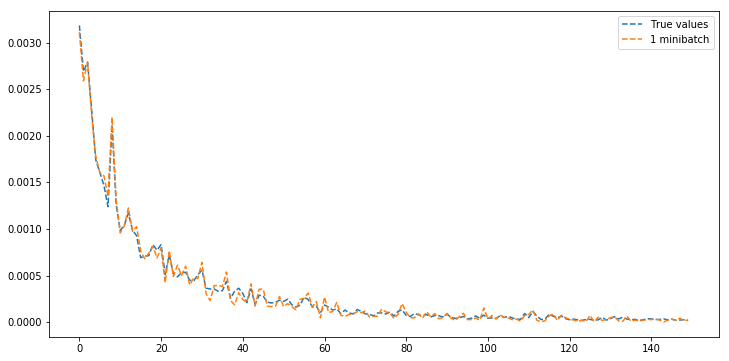

In [4]:
filename = '../../results/estimates'

results = np.load(f'{filename}.npz')

true_values = results['train_loss']
n_epochs = len(true_values)

estimated_values = results['train_loss_sample']

fix, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, n_epochs), true_values, '--', label='True values')
ax.plot(np.arange(0, n_epochs), estimated_values[0], '--', label='1 minibatch')

ax.legend()
plt.show()

Even one single minibatch seems to be effective.

Let's increase up to 10.

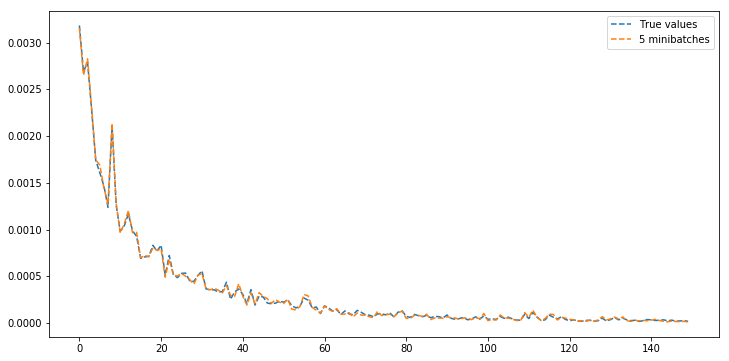

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, n_epochs), true_values, '--', label='True values')
ax.plot(np.arange(0, n_epochs), estimated_values[4], '--', label='5 minibatches')

ax.legend()
plt.show()

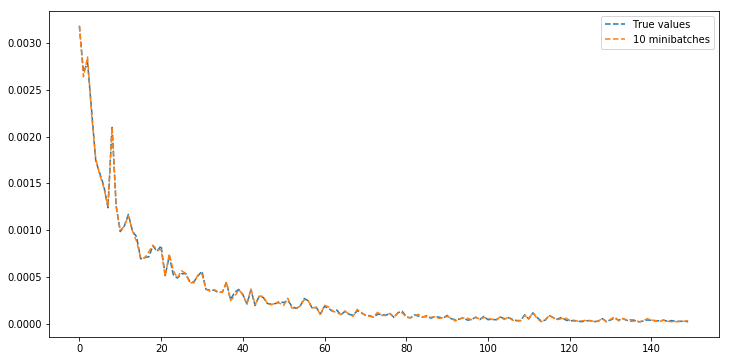

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(np.arange(0, n_epochs), true_values, '--', label='True values')
ax.plot(np.arange(0, n_epochs), estimated_values[9], '--', label='10 minibatches')

ax.legend()
plt.show()

del results

The RMSE can tell us more, about each estimator (from 1 up to 10 minibatches). 

10 minibatches, equivalent to 5120 images, seem to be a sufficient number to estimate the training loss.

In [7]:
import math
errors = [['Number of minibatches', 'RMSE']]

for i in range(10):
    errors.append([f"{i + 1}",
                   math.sqrt(metrics.mean_squared_error(true_values, estimated_values[i]))])

display(HTML(tabulate.tabulate(errors, tablefmt='html')))

Number of minibatches,RMSE
1,4.470675069326005e-05
2,3.6272676208033735e-05
3,2.9091968206026498e-05
4,2.3681932997693578e-05
5,2.0638309025328894e-05
6,2.3025004559846882e-05
7,1.9495580780342515e-05
8,2.150131052112069e-05
9,1.5199191194983499e-05
10,1.536748580971172e-05


The RMSE drops by a factor of ~ 3. In the following tests 10 minibatches have been used to estimate the training loss.

## Comparison optimizers

The common optimizers are tested to find the fastest and most stable one.

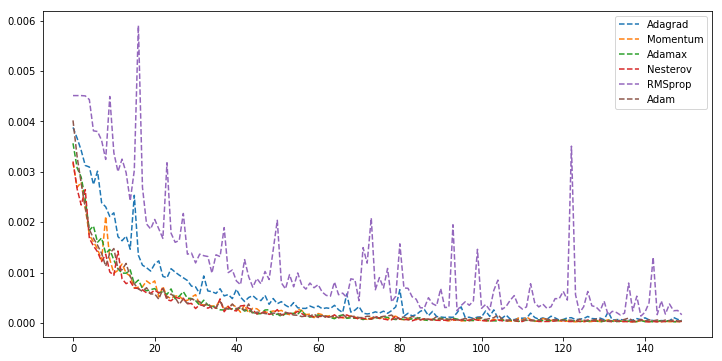

In [8]:
results = {}
for filename in glob.glob('../../results/optimizerComparison/*.npz'):
    filename_filtered = filename.split("/")[-1].split(".")[0]
    results.update({filename_filtered: np.load(filename)})

fig, ax = plt.subplots(figsize=(12, 6))

for name, result in results.items():
    
    n_epochs = len(result['train_loss'])
    ax.plot(np.arange(0, n_epochs), result['train_loss'], '--', label=name)
    
ax.legend()
plt.show()

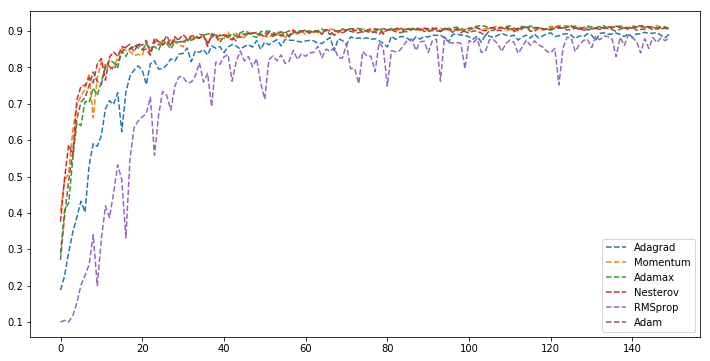

In [9]:
fig, ax = plt.subplots(figsize=(12, 6))

for name, result in results.items():
    
    n_epochs = len(result['validation_accuracy'])
    ax.plot(np.arange(0, n_epochs), result['validation_accuracy'], '--', label=name)
    
ax.legend()
plt.show()

Vanilla SGD with momentum set to 0.9 has been used for the following tests.

# Restart


The restart techinque uses the function above to estimate training loss and to restart the computation when needed. Epsilon is the restart barrier: once below the model is deleted. This funcion is called at the end of each epoch. 

In [10]:
def restart(trainloader, model, args, optimizer, epsilon=0.0004):
    
    train_cost, train_accuracy = test_train_sample(trainloader, model, n_minibatches=10)

    if train_cost < epsilon:
        print("Restart")
        
        del model
        del optimizer

        model = load_net(net=args.net, dataset_name=args.dataset)
        if args.gpu:
            model = model.cuda()

        optimizer = choose_optimizer(model, args)

    return model, optimizer, train_cost, train_accuracy

Looking at the results on the cluster it seems that epsilon is too high and should be decreased.

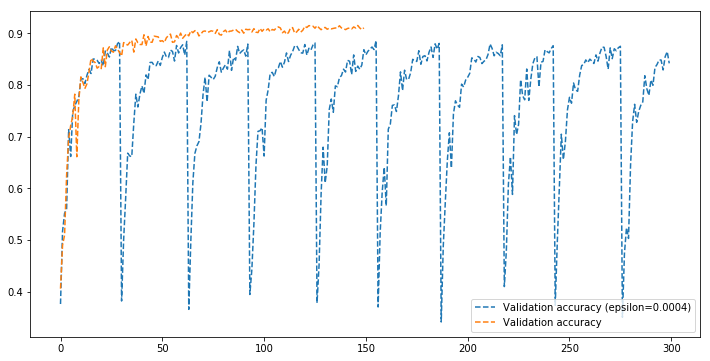

In [11]:
filename = '../../results/restart_on_training/results'
filename2 = '../../results/estimates'

restart_results = np.load(f'{filename}.npz')
standard_results = np.load(f'{filename2}.npz')

fix, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.arange(0, len(restart_results['validation_accuracy'])), 
        restart_results['validation_accuracy'], '--', label='Validation accuracy (epsilon=0.0004)')
ax.plot(np.arange(0, len(standard_results['validation_accuracy'])), 
        standard_results['validation_accuracy'], '--', label='Validation accuracy')


ax.legend()
plt.show()

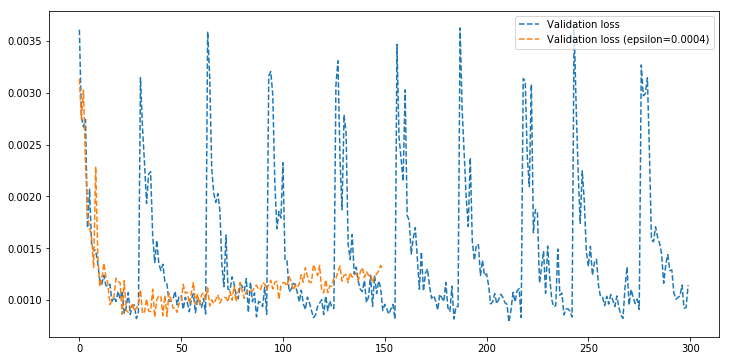

In [12]:
fix, ax = plt.subplots(figsize=(12, 6))

ax.plot(np.arange(0, len(restart_results['validation_loss'])), 
        restart_results['validation_loss'], '--', label='Validation loss')
ax.plot(np.arange(0, len(standard_results['validation_loss'])), 
        standard_results['validation_loss'], '--', label='Validation loss (epsilon=0.0004)')


ax.legend()
plt.show()